In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from src.utils import *
from src.utils_TP5 import *
from src.knn_validation import knn_simple_validation
from sklearn.base import BaseEstimator
data = pd.read_csv('../dataset/data_5diagnosis.csv')
df = data.drop('Diagnosis', axis=1)

In [2]:
def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_markerfacecolor()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)

In [3]:
models = [
(LinearDiscriminantAnalysis, "LDA"),
(QuadraticDiscriminantAnalysis, "QDA"),
(GaussianNB, "NB"),
]
def validation_errors(df, models):
    y = df.z
    X = df.drop(columns=["z"])
    for model, name in models:
        for acc in cross_val_score(model(), X, y, cv=10):
            yield name, acc
            
def add_decision_boundaries(df, models):
    colors = sns.color_palette()
    for model, name in models:
        y = df.z
        X = df.drop(columns=["z"])
        cls = model()
        cls.fit(X, y)
        add_decision_boundary(cls, label=name, color=colors.pop(), region=False)
        
def add_decision_boundaries(df, model, name):
    colors = sns.color_palette()
    y = df.z
    X = df.drop(columns=["z"])
    cls = model()
    cls.fit(X, y)
    add_decision_boundary(cls, label=name, color=colors.pop(), region=False)

Chargement du jeu de l'ACP

In [4]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
#X = X - X.mean()
pca = PCA(n_components=2)
pcs = pca.fit_transform(X)
pcs = pd.DataFrame(pcs,columns=[f"PC{i}" for i in range(1, 3)])
X['z'] = data['Diagnosis']
pcs['z'] = data['Diagnosis']

### Visualisation des frontières des modèles sur l'ACP

C:\Users\remsb\OneDrive - etu.utc.fr\P24\SY09\projet\projet-sy09\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


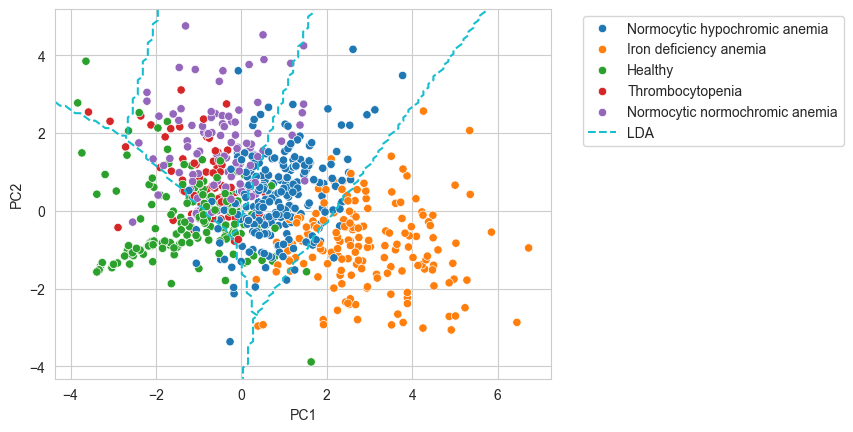

C:\Users\remsb\OneDrive - etu.utc.fr\P24\SY09\projet\projet-sy09\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


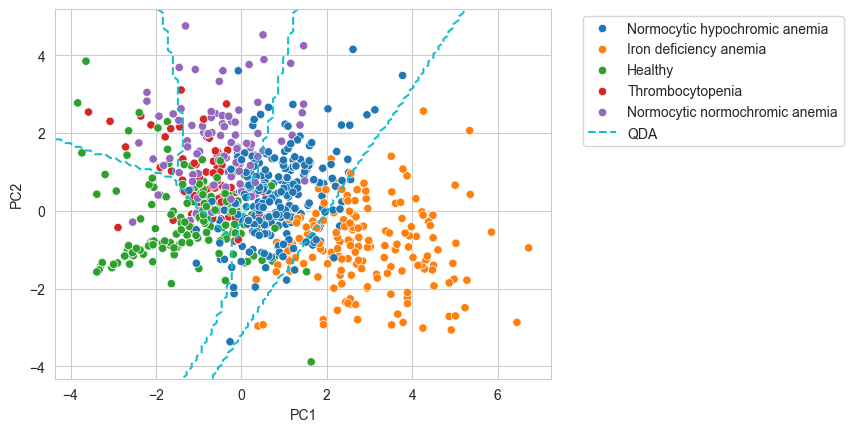

C:\Users\remsb\OneDrive - etu.utc.fr\P24\SY09\projet\projet-sy09\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


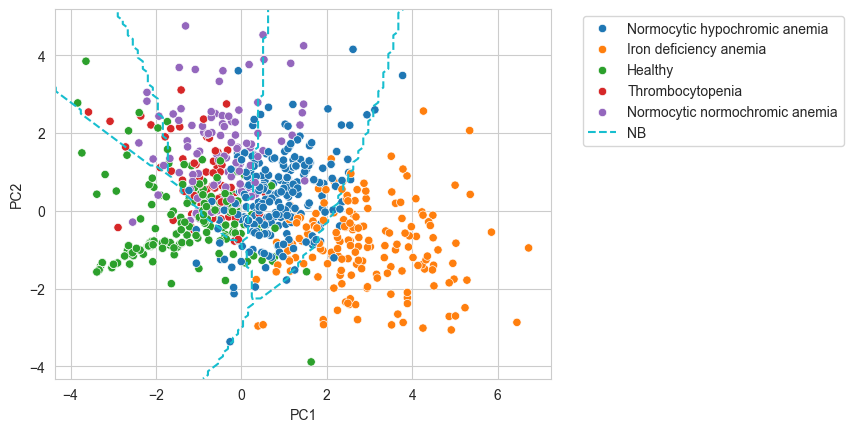

In [5]:
for model, nom in models:    
    sns.scatterplot(x="PC1", y="PC2", data=pcs, hue="z")
    add_decision_boundaries(pcs, model, nom)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

### Evolution des modèles sur le jeu de données

C:\Users\remsb\AppData\Local\Temp\ipykernel_24092\2048590055.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x="Model", y="Acc", data=pcs, ci="sd")


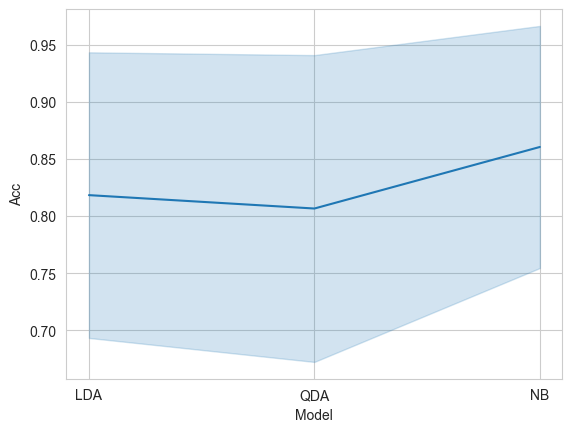

In [6]:
X['z'] = data['Diagnosis']
pcs = pd.DataFrame(validation_errors(X, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=pcs, ci="sd")
plt.show()